In [95]:
import pandas as pd
import numpy as np

# Load data
df_h = pd.read_csv("./data/human_perf_pr_ccn_deltas.csv")
df_ai = pd.read_csv("./data/ai_perf_pr_ccn_deltas.csv")

# Convert empty strings to NaN for easier filtering
for df in (df_h, df_ai):
    df.replace("", np.nan, inplace=True)

# List of required metrics
REQUIRED_METRICS = ["Total nloc", "AvgCCN", "Fun Cnt"]

def filter_complete_prs(df):
    # Keep only the rows for required metrics
    sub = df[df["metric"].isin(REQUIRED_METRICS)]

    # Pivot so each PR_ID has columns for each metric's delta values
    # You can choose any column to test completeness; delta or optimized are both fine
    pivot = sub.pivot_table(
        index="pr_id",
        columns="metric",
        values="optimized",   # or "delta" or "original"
        aggfunc="first"
    )

    # Keep only PRs where all metric columns are present (not NaN)
    complete_pr_ids = pivot.dropna().index

    # Return the filtered dataframe (all rows belonging to these PR IDs)
    return df[df["pr_id"].isin(complete_pr_ids)]

# Apply filtering
df_h_complete = filter_complete_prs(df_h)
df_ai_complete = filter_complete_prs(df_ai)

print("Human PRs before:", df_h["pr_id"].nunique())
print("Human PRs after filtering:", df_h_complete["pr_id"].nunique())

print("AI PRs before:", df_ai["pr_id"].nunique())
print("AI PRs after filtering:", df_ai_complete["pr_id"].nunique())

# Save output
df_h_complete.to_csv("./data/human_perf_pr_ccn_deltas_complete.csv", index=False)
df_ai_complete.to_csv("./data/ai_perf_pr_ccn_deltas_complete.csv", index=False)


Human PRs before: 78
Human PRs after filtering: 62
AI PRs before: 315
AI PRs after filtering: 279


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1. Load complete-data filtered maintainability deltas
# -------------------------------------------------------------------
df_h = pd.read_csv("./data/human_perf_pr_ccn_deltas_complete.csv")
df_ai = pd.read_csv("./data/ai_perf_pr_ccn_deltas_complete.csv")

df_h["pr_type"] = "Human"
df_ai["pr_type"] = "AI"

df = pd.concat([df_h, df_ai], ignore_index=True)

# Ensure numeric columns
for col in ["original", "optimized", "delta", "delta_pct"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -------------------------------------------------------------------
# 2. Aggregate maintainability delta per PR
# -------------------------------------------------------------------
# You can choose mean, sum, or median. Mean is recommended.
agg_df = (
    df.groupby(["pr_id", "pr_type", "metric"], as_index=False)
      .agg({"delta": "mean", "delta_pct": "mean"})
)

# Pivot so each metric becomes a feature
wide_df = agg_df.pivot_table(
    index=["pr_id", "pr_type"],
    columns="metric",
    values="delta_pct"
).reset_index()

# Standardize column names
wide_df.columns.name = None

print("\n=== Aggregated PR-level Dataset Preview ===")
print(wide_df.head())

# -------------------------------------------------------------------
# 3. Summary statistics for AI vs Human
# -------------------------------------------------------------------
summary = wide_df.groupby("pr_type").agg(["mean", "median", "std", "count"])
print("\n=== Summary Statistics (PR-Level) ===")
print(summary)



=== Aggregated PR-level Dataset Preview ===
        pr_id pr_type   Avg.NLOC  Avg.token     AvgCCN    Fun Cnt  Total nloc
0  2260441374   Human -26.724138 -27.408299 -53.383459 -69.444444  -70.312500
1  2260678480   Human   8.163265   7.990315 -12.500000   0.000000   10.447761
2  2269709704   Human   3.914002   0.721812  -0.773196  12.000000   20.807453
3  2277950711   Human   0.095785   0.152594   0.328947   0.000000    0.081766
4  2303501996   Human   0.290698   0.310647   0.211864   0.000000    0.246427

=== Summary Statistics (PR-Level) ===
                pr_id                                    Avg.NLOC            \
                 mean        median           std count      mean    median   
pr_type                                                                       
AI       3.156199e+09  3.181364e+09  8.304945e+07   279  3.036706  0.018812   
Human    2.455485e+09  2.452658e+09  1.093496e+08    62  1.361349  0.171289   

                         Avg.token            ...   

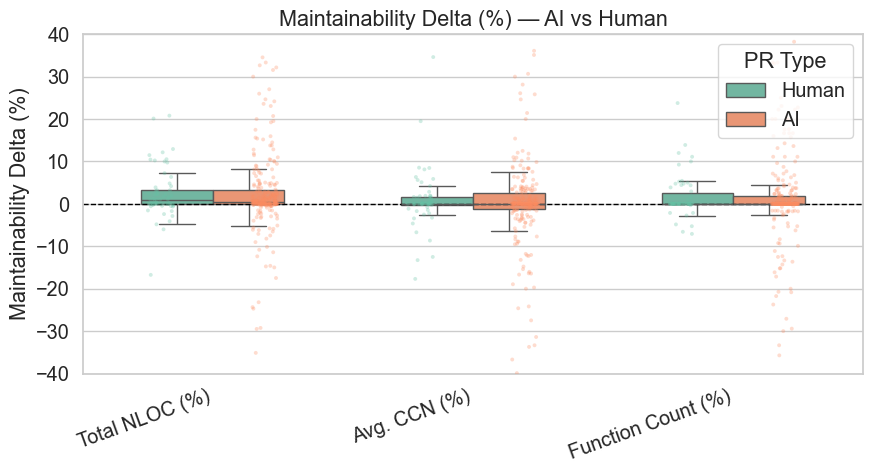

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------
# Melt data for plotting
# ----------------------------------------
melt_df = wide_df.melt(
    id_vars=["pr_type"],
    value_vars=["Total nloc", "AvgCCN", "Fun Cnt"],
    var_name="metric",
    value_name="delta"
)

# Clean metric labels for readability
label_map = {
    "Total nloc": "Total NLOC (%)",
    "AvgCCN": "Avg. CCN (%)",
    "Fun Cnt": "Function Count (%)"
}
melt_df["metric"] = melt_df["metric"].map(label_map)

# Metric ordering
order = ["Total NLOC (%)", "Avg. CCN (%)", "Function Count (%)"]

# ----------------------------------------
# Plot
# ----------------------------------------
plt.figure(figsize=(9, 5))

ax = sns.boxplot(
    data=melt_df,
    x="metric",
    y="delta",
    hue="pr_type",
    order=order,
    width=0.55,
    fliersize=0,
    palette="Set2"
)

# Jittered points (only for deltas within zoomed range)
sns.stripplot(
    data=melt_df[(melt_df["delta"].abs() <= 40)],
    x="metric",
    y="delta",
    hue="pr_type",
    order=order,
    dodge=True,
    alpha=0.30,
    size=2.8,
    palette="Set2",
    ax=ax
)

# ----------------------------------------
# Formatting
# ----------------------------------------
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.ylim(-40, 40)

plt.xticks(rotation=20, ha="right")
plt.ylabel("Maintainability Delta (%)")
plt.xlabel("")

plt.title("Maintainability Delta (%) — AI vs Human")

# Remove duplicate legends (stripplot adds duplicates)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="PR Type", loc="upper right")

plt.tight_layout()
# Save the plot to file
plt.savefig("./data/maintainability_delta_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()



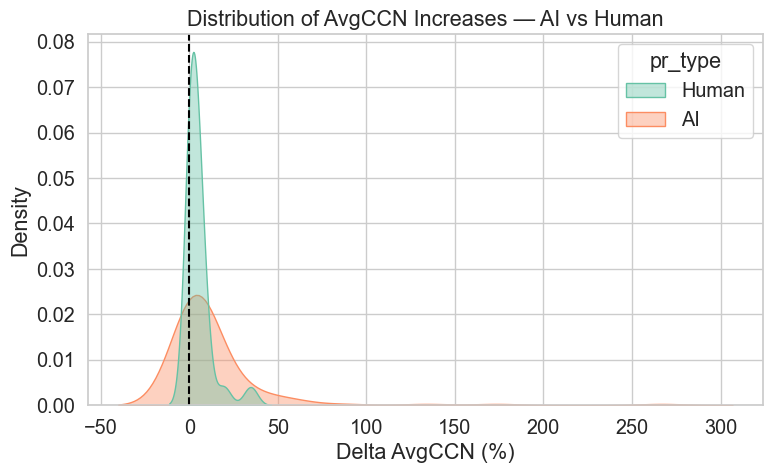

In [92]:
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=ccn_inc_df,
    x="delta",
    hue="pr_type",
    common_norm=False,
    fill=True,
    alpha=0.4,
    palette="Set2"
)

plt.title("Distribution of AvgCCN Increases — AI vs Human")
plt.xlabel("Delta AvgCCN (%)")
plt.ylabel("Density")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.savefig("./data/maintainability_distribution_avgccn.png", dpi=300, bbox_inches="tight")


In [93]:
# Extract PR-level AvgCCN deltas
ccn_df = wide_df[["pr_id", "pr_type", "AvgCCN"]].copy()

# Mark PRs where AvgCCN increased
ccn_df["ccn_increased"] = ccn_df["AvgCCN"] > 0

# Compute rate per PR type
ccn_rate = (
    ccn_df.groupby("pr_type")["ccn_increased"]
          .mean()
          .reset_index()
)

ccn_rate["percentage"] = ccn_rate["ccn_increased"] * 100
print(ccn_rate)


  pr_type  ccn_increased  percentage
0      AI       0.401434   40.143369
1   Human       0.419355   41.935484
